In [92]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol
from scipy.stats import norm

sympy.init_printing()

In [93]:
basis = 'leguerre'

# parameters

mu = 0.02
r = 0.02
T = 1
I = 250
paths = 1000
S0 = 40
S0_list = range(37, 43, 1)
m = 0
K = 40

GBM_sigma = 0.04
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

In [94]:
import numpy as np
from scipy.stats import qmc, norm

def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)

    # Shuffle the Halton sequence
    np.random.shuffle(x_halton)

    # Apply the norm.ppf transformation to the shuffled sequence
    return norm.ppf(x_halton)

In [95]:
def gbm_paths(S0, mu, sigma, T, I, paths):
    np.random.seed(42)
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    matrix = np.zeros((paths, I))
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = np.random.standard_normal()
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

gbm_paths_result = gbm_paths(S0, GBM_mu, GBM_sigma, T, I, paths)

In [96]:
def gbm_paths_halton(S0, mu, sigma, T, I, paths):
    dt = T / I
    matrix = np.zeros((paths, I))

    # Generate a Halton sequence for all paths and time steps
    Z_sequence = halton_norm(paths * I).reshape(paths, I)

    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            # Use a unique value from the Halton sequence for each time step of each path
            Z = Z_sequence[k, i]
            S[i] = S[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

gbm_paths_halton_result = gbm_paths_halton(S0, GBM_mu, GBM_sigma, T, I, paths)

In [97]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    np.random.seed(42)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    variance = np.var(V[:, 1] * df)
    return V0, V0_array, SE, variance

In [98]:
V0_quasi, V0_array_quasi, SE_quasi, variance_quasi = LSM(K, gbm_paths_halton_result, I, np.exp(-r * T), basis, 2)
V0, V0_array, SE, variance = LSM(K, gbm_paths_result, I, np.exp(-r * T), basis, 2)

print('Quasi-random numbers')
print('V0: ', V0_quasi.round(5))
print('SE: ', SE_quasi.round(5))
print('Variance: ', variance_quasi.round(5))
print('Random numbers')
print('V0: ', V0.round(5))
print('SE: ', SE.round(5))
print('Variance: ', variance.round(5))

Quasi-random numbers
V0:  0.15929
SE:  0.00501
Variance:  0.02508
Random numbers
V0:  0.16038
SE:  0.00518
Variance:  0.02682


In [99]:
print('Quasi-random numbers')
print('V0: ', V0_quasi.round(5))
print('SE: ', SE_quasi)
print('Variance: ', variance_quasi.round(5))
print('Random numbers')
print('V0: ', V0.round(5))
print('SE: ', SE)
print('Variance: ', variance.round(5))

Quasi-random numbers
V0:  0.15929
SE:  0.0050080599367203354
Variance:  0.02508
Random numbers
V0:  0.16038
SE:  0.005178969816438123
Variance:  0.02682


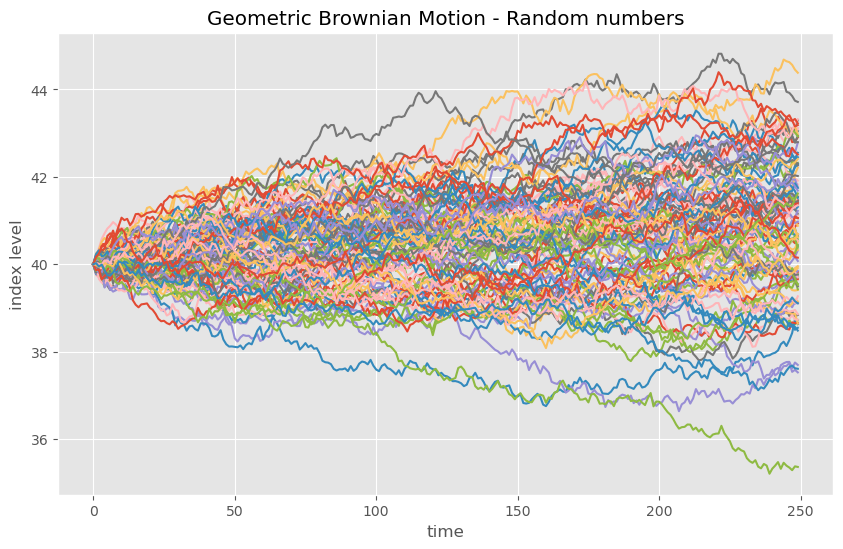

In [100]:
#plot both paths
plt.figure(figsize=(10, 6))
plt.plot(gbm_paths_result[:100].T, lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.title('Geometric Brownian Motion - Random numbers')
plt.show()

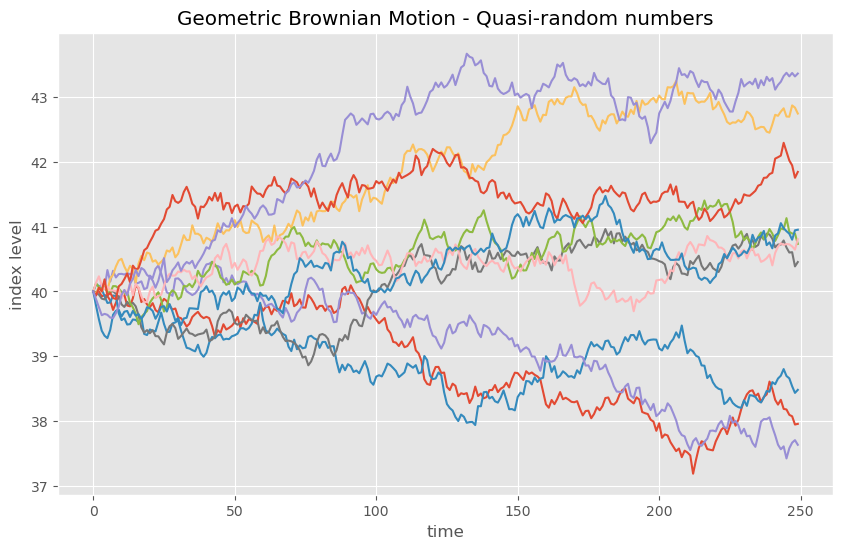

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(gbm_paths_halton_result[:10].T, lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.title('Geometric Brownian Motion - Quasi-random numbers')
plt.show()
